# Introduction:

In this Notebook, I try to learn and build the Long Short-Term Memory (LSTM) recurrent neural network to fit one third of data and then predict the rest of data.
    
Database information:
    
(1) date: Date in format dd/mm/yyyy

(2) time: time in format hh:mm:ss

(3) global_active_power: household global minute-averaged active power (in kilowatt)

(4) global_reactive_power: household global minute-averaged reactive power (in kilowatt)

(5) voltage: minute-averaged voltage (in volt)

(6) global_intensity: household global minute-averaged current intensity (in ampere)

(7) sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

(8) sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

(9) sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

In [1]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


# Step 1: Import & cleaning data

Importing the txt file takes more time than that of csv file.

In [3]:
df = pd.read_csv(r'C:\Users\2MY\Documents\Uni Work\Level 4\TR-Y4-Project\LSTM_Prac\household_power_consumption.txt\household_power_consumption.txt', 
                 sep=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

C:\Users\2MY\AppData\Local\Temp\ipykernel_24568\1316280536.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(r'C:\Users\2MY\Documents\Uni Work\Level 4\TR-Y4-Project\LSTM_Prac\household_power_consumption.txt\household_power_consumption.txt',
C:\Users\2MY\AppData\Local\Temp\ipykernel_24568\1316280536.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(r'C:\Users\2MY\Documents\Uni Work\Level 4\TR-Y4-Project\LSTM_Prac\household_power_consumption.txt\household_power_consumption.txt',
C:\Users\2MY\AppData\Local\Temp\ipykernel_24568\1316280536.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False 

In [4]:
df.shape

(2075259, 7)

This database have 2,075,259 rows and 7 columns. Let's check the NA data and fill na data with the mean values.

In [5]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

# Step 2: Data visualizations

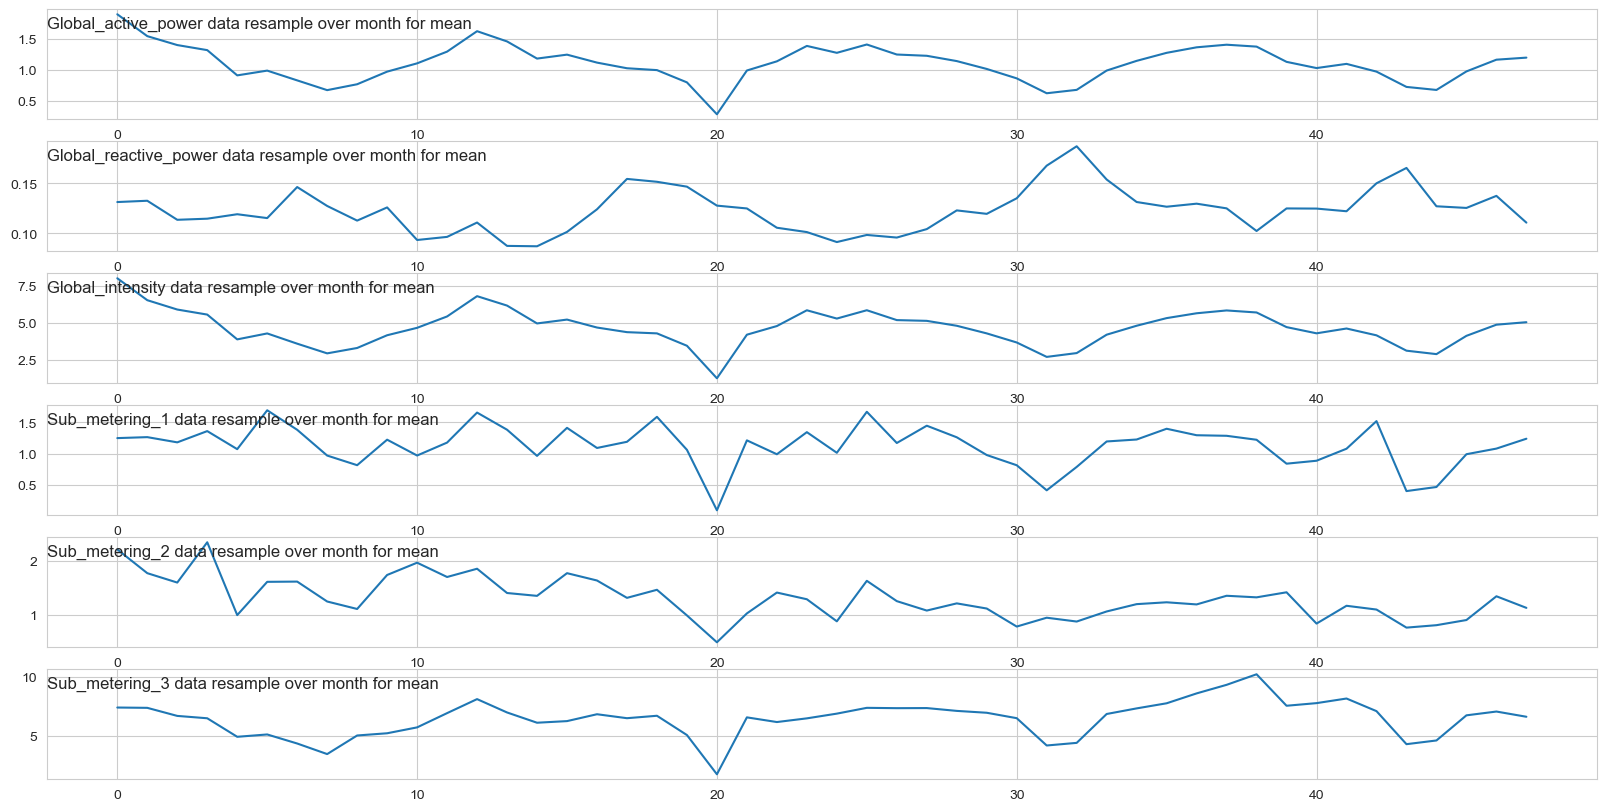

In [16]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('ME').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

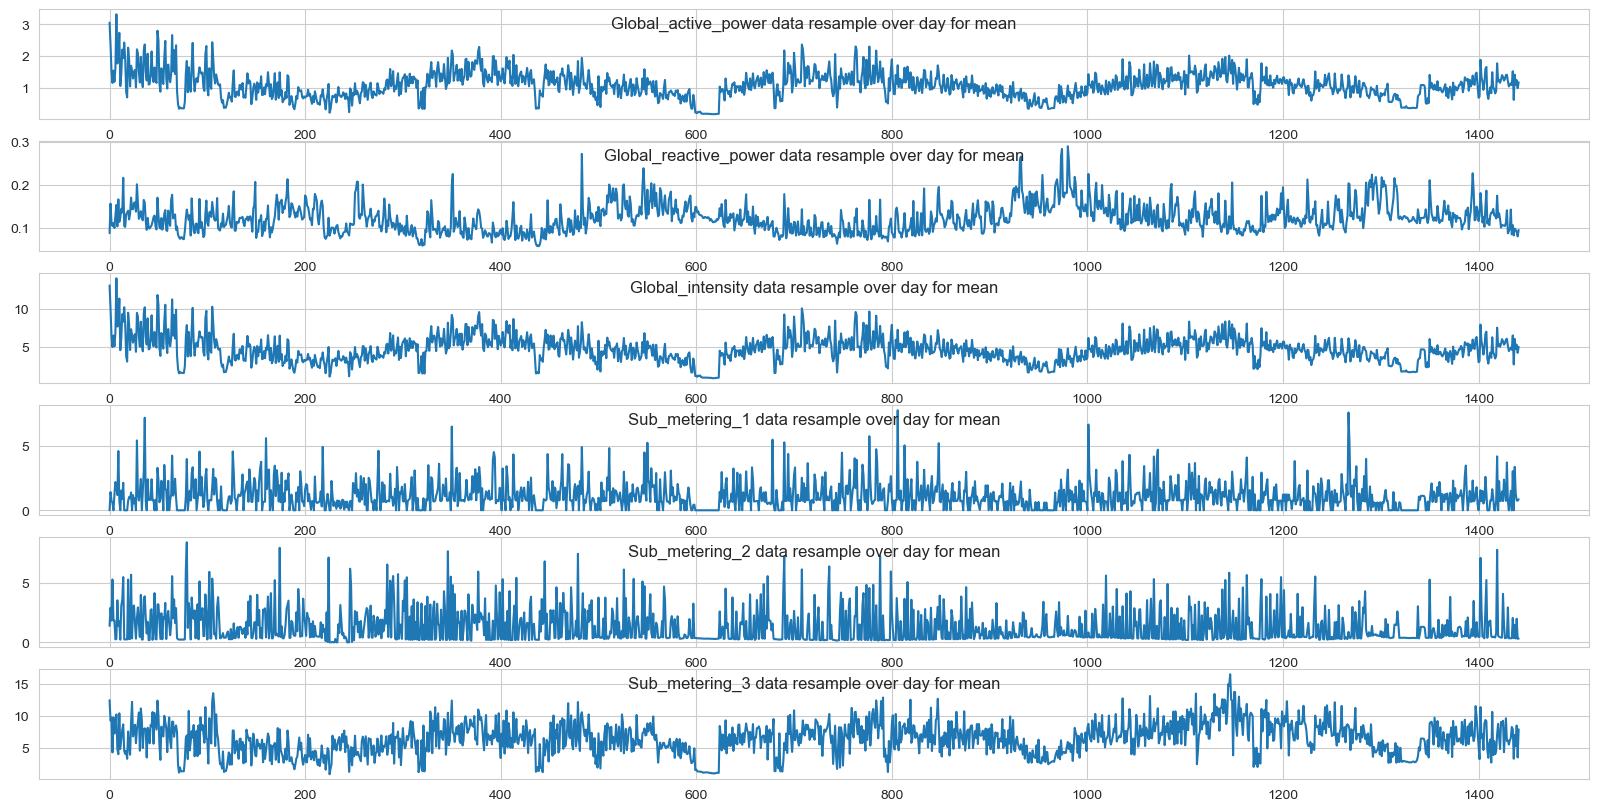

In [17]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

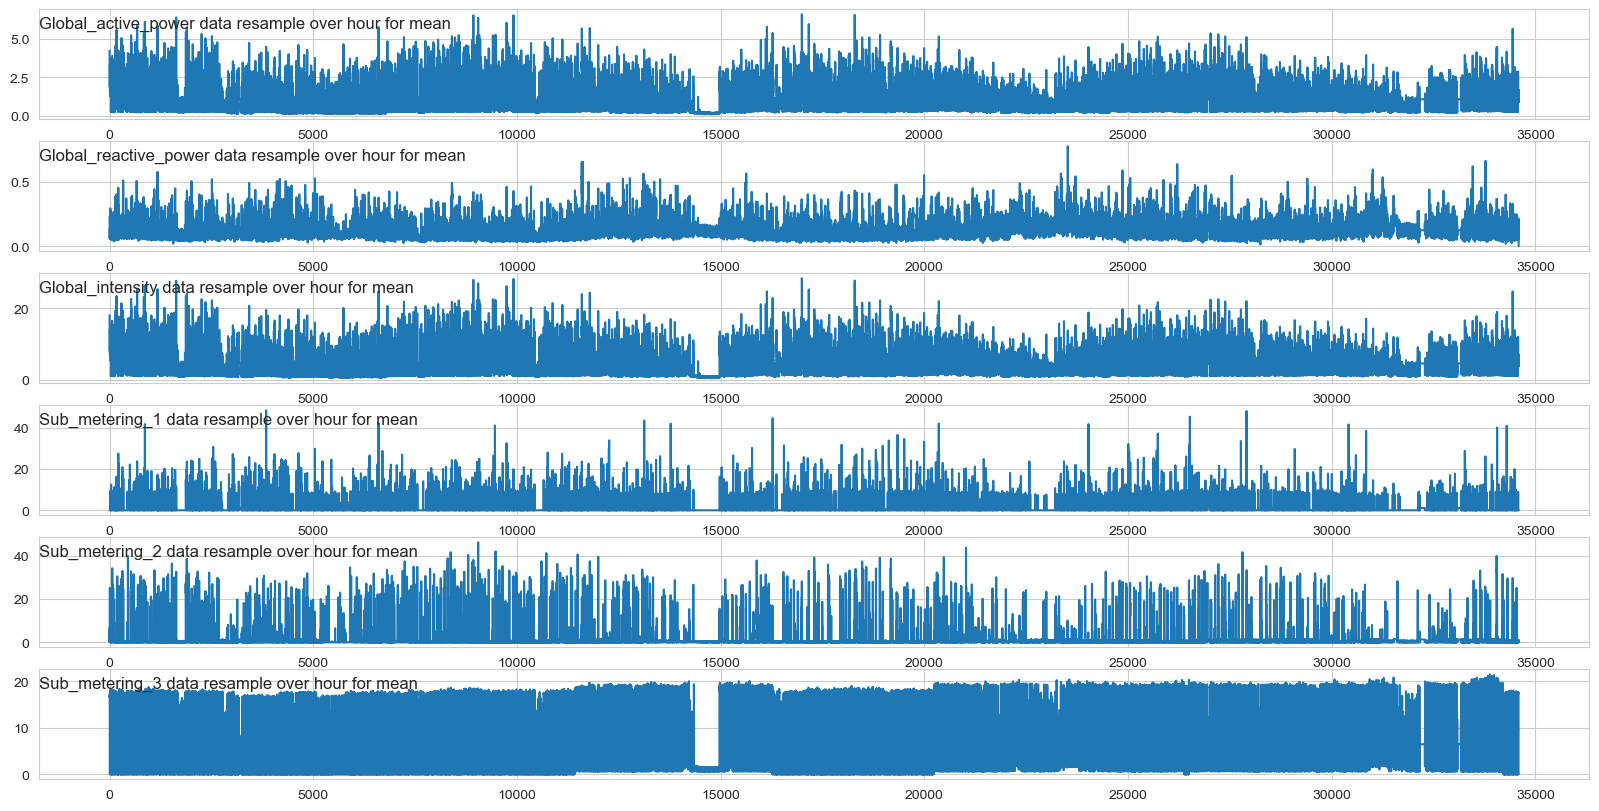

In [19]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('h').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

# From above visualizations:

+ the resampling by month, date or hour is very important because it has a large interaction as expected (changing the periodicity of the system). 
+ Therefore, if processing all the original data, the runtime will be very costly, but if processing data with large time-scale samples (e.g. monthly), it will affect the model's predictivity. 
+ From observation, we can see, it is relatively reasonable to resample data by hour.

In [20]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


From above table, it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated.

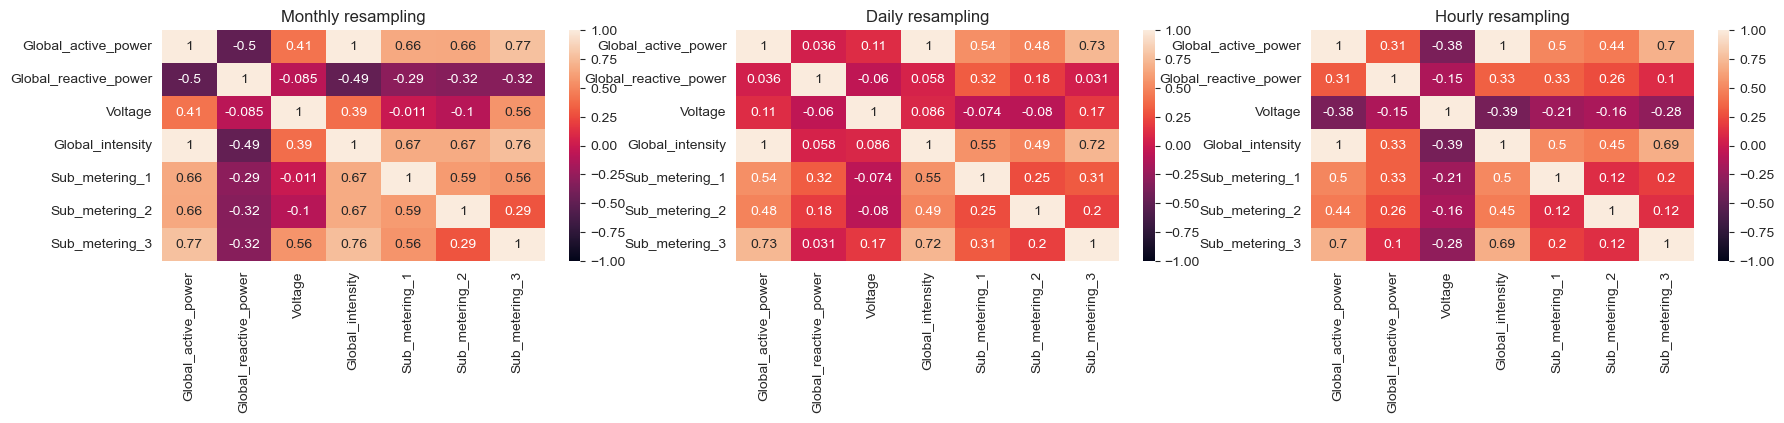

In [22]:
import seaborn as sns
f= plt.figure(figsize=(21,3))

ax=f.add_subplot(131)
dfm = df.resample('ME').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

ax=f.add_subplot(132)
dfd = df.resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)
  
ax=f.add_subplot(133)
dfh = df.resample('h').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)
plt.show()

It is seen from above that with resampling techniques one can change the correlations among features.

# Step 3: LSTM Data Preparation and fitting

The LSTM nueral network has been selected because:

+ it is best suited for large data, 
+ time-seriers, and 
+ sequential problem.

In the first step, I will frame the problem to predict the Global_active_power.

In [9]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In order to reduce the computation time, and also get a quick result to test the model. We have resampled the data over hour to reduce the size of data from 2075259 to 34589 (data are given in minutes).

In [11]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

So, we will have 7 input series variables and the 1 output variable for 'Global_active_power' at the current time in hour.

We also splitting the data into: train and validation sets. I select 4000 data over 34,589 dat to train, the rest will be used to test the model.

In [12]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

<h3> LSTM model setting <h3>

(1) 100 neurons in the first visible layer

(2) dropout 10%

(3) 1 neuron in the output layer for predicting Global_active_power

(4) The input shape will be 1 time step with 7 features

(5) The mean_squared_error loss function and the efficient adam version of stochastic gradient descent

(6) The model will be fit for 50 training epochs with a batch size of 70.

In [13]:
print(keras.__version__)

3.9.0


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [17]:
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.612


Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.

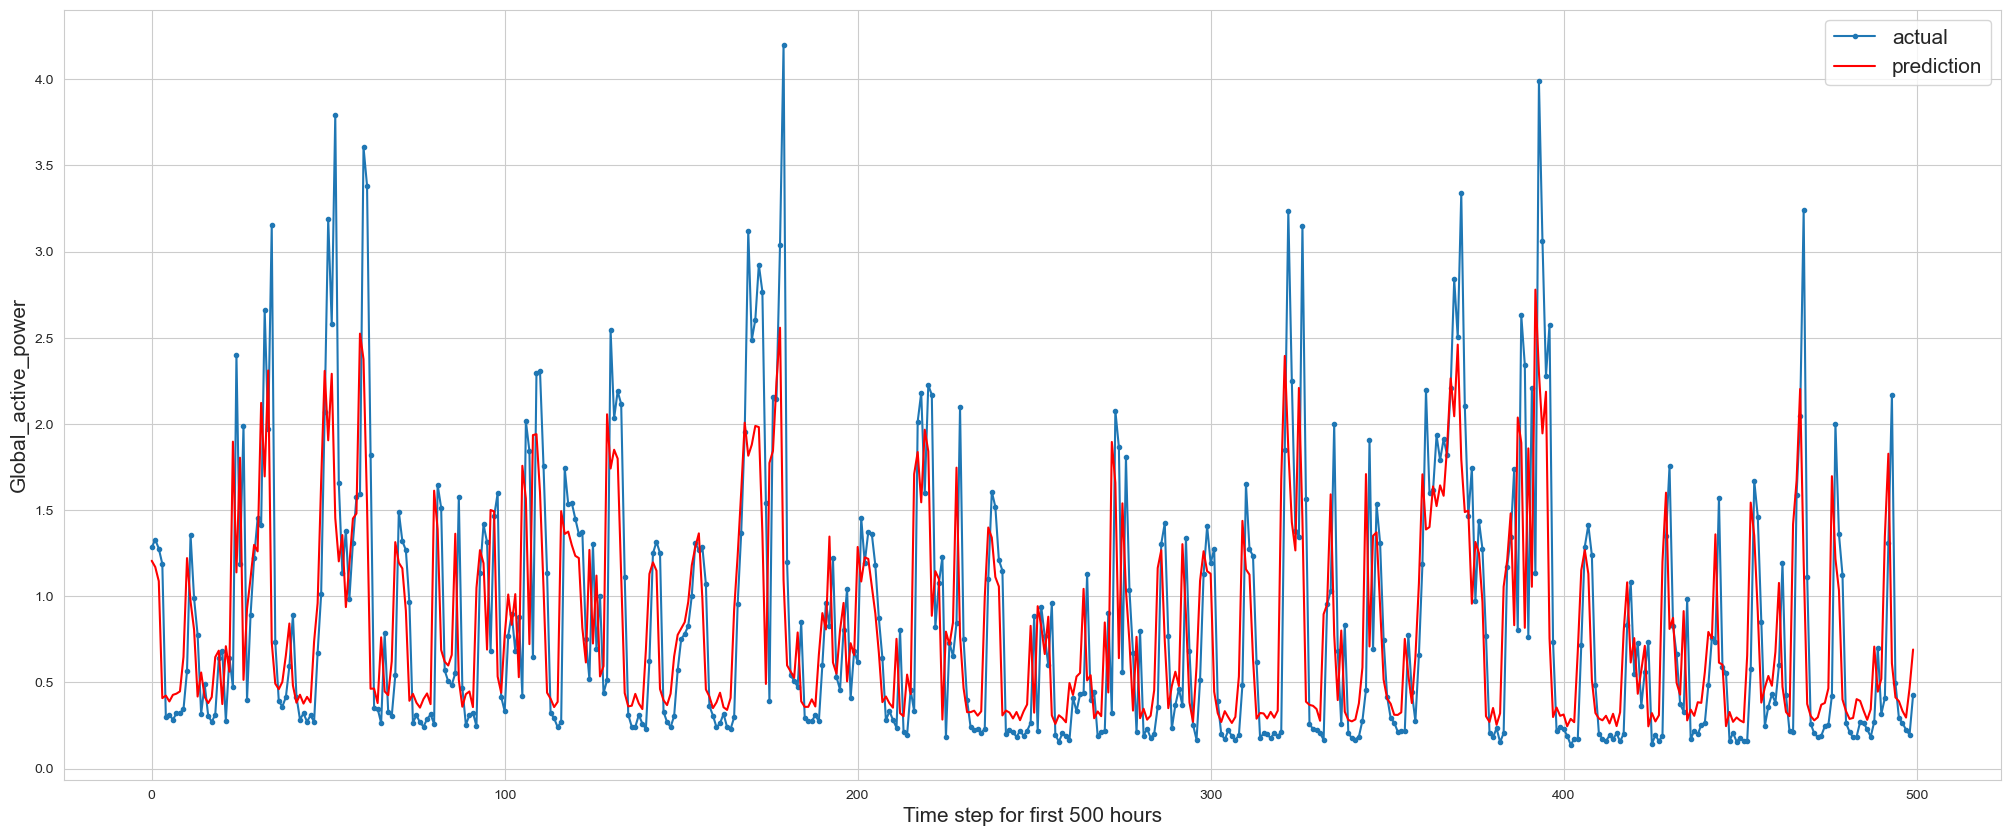

In [18]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

In [19]:
inv_yhat[1]

1.169911307581266

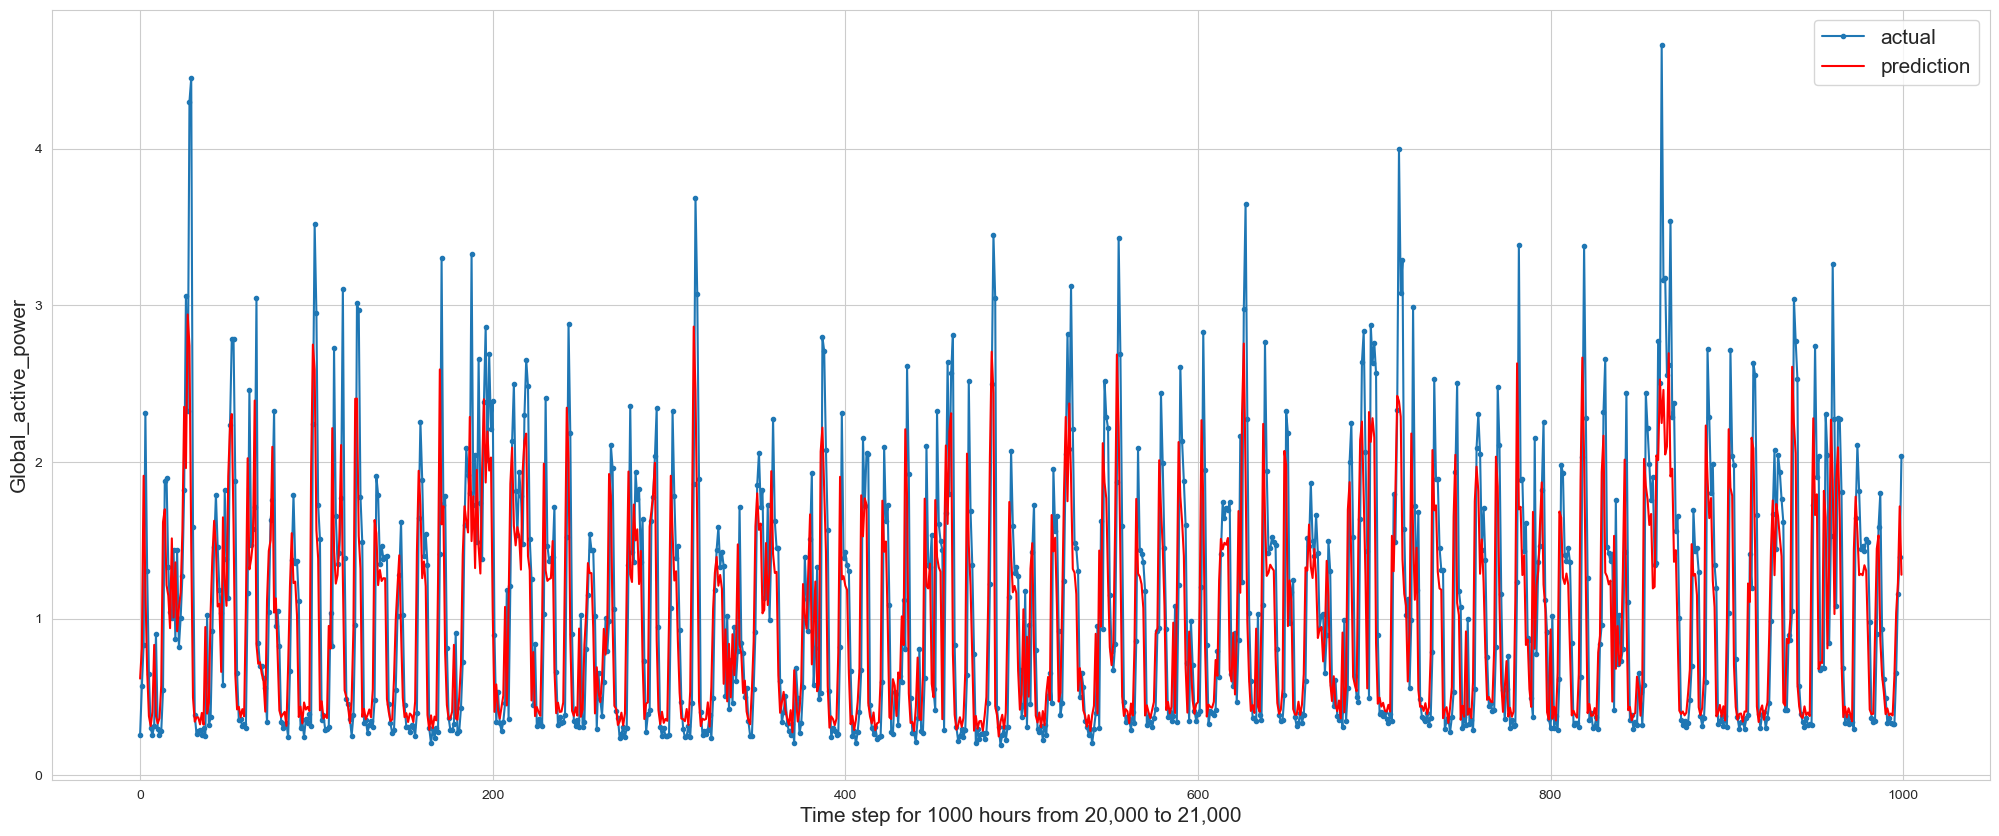

In [20]:
aa=[x for x in range(1000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[20000:21000], marker='.', label="actual")
plt.plot(aa, inv_yhat[20000:21000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for 1000 hours from 20,000 to 21,000', size=15)
plt.legend(fontsize=15)
plt.show()

Now, let's try to fit and predict the Sub_metering_3

In [22]:
df = df[['Sub_metering_3','Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1']]

In [23]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [24]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/250
40/40 - 1s - loss: 0.1297 - val_loss: 0.0904
Epoch 2/250
40/40 - 1s - loss: 0.0852 - val_loss: 0.0796
Epoch 3/250
40/40 - 0s - loss: 0.0762 - val_loss: 0.0734
Epoch 4/250
40/40 - 0s - loss: 0.0712 - val_loss: 0.0706
Epoch 5/250
40/40 - 1s - loss: 0.0691 - val_loss: 0.0694
Epoch 6/250
40/40 - 1s - loss: 0.0676 - val_loss: 0.0687
Epoch 7/250
40/40 - 1s - loss: 0.0674 - val_loss: 0.0685
Epoch 8/250
40/40 - 1s - loss: 0.0670 - val_loss: 0.0685
Epoch 9/250
40/40 - 1s - loss: 0.0667 - val_loss: 0.0686
Epoch 10/250
40/40 - 0s - loss: 0.0668 - val_loss: 0.0686
Epoch 11/250
40/40 - 0s - loss: 0.0667 - val_loss: 0.0686
Epoch 12/250
40/40 - 0s - loss: 0.0667 - val_loss: 0.0688
Epoch 13/250
40/40 - 0s - loss: 0.0665 - val_loss: 0.0688
Epoch 14/250
40/40 - 0s - loss: 0.0667 - val_loss: 0.0690
Epoch 15/250
40/40 - 0s - loss: 0.0665 - val_loss: 0.0690
Epoch 16/250
40/40 - 0s - loss: 0.0666 - val_loss: 0.0692
Epoch 17/250
40/40 - 0s - loss: 0.0667 - val_loss: 0.0692
Epoch 18/250
40/40 - 0s

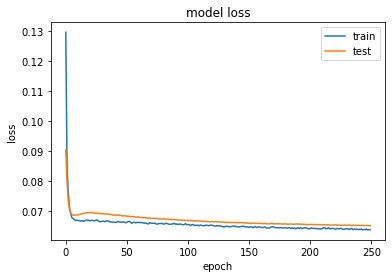

Test RMSE: 5.494


In [25]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=250, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

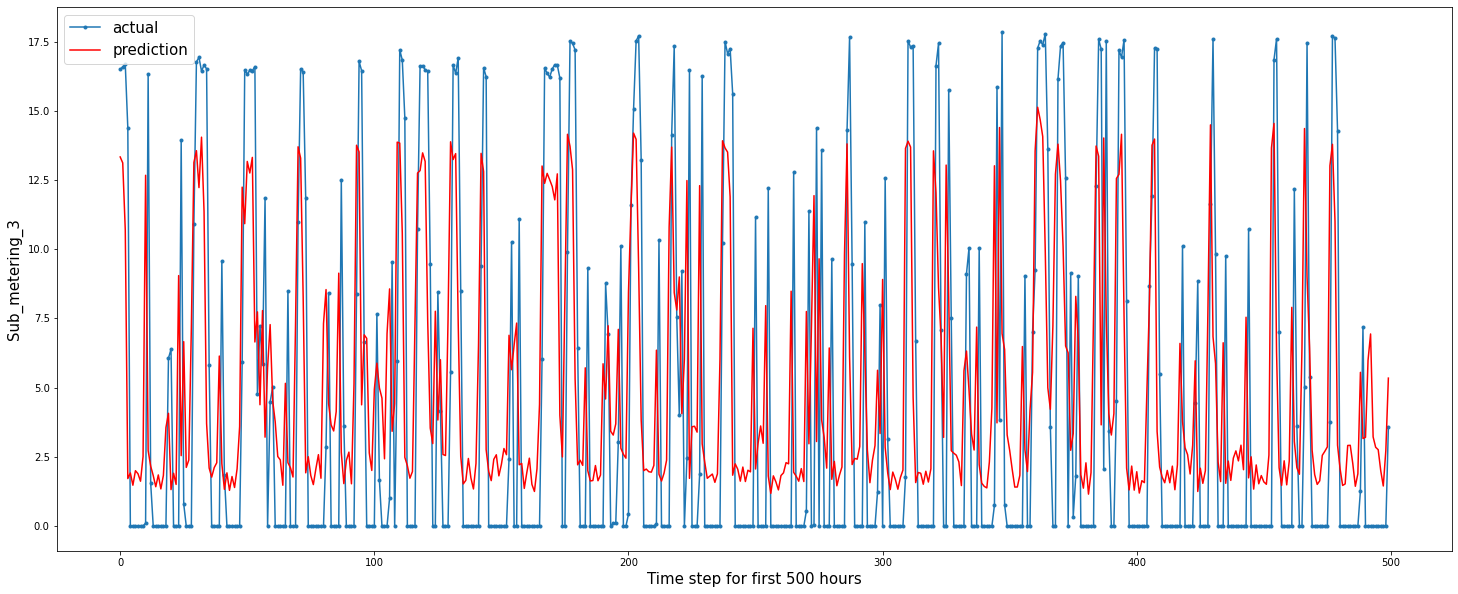

In [27]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

Let's try to fit and predict the "Global_active_power" parameter, but this time, we do not need to include the "Voltage" data series in the database, since this is expected to NOT effect MUCH to the "Global_active_power" parameter.

In [28]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
df = df.drop(['Voltage'],axis=1)

In [29]:
df.shape

(2075259, 6)

We resample as the previous procedure, and we have ONLY 6 columns in the database.

In [30]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 6)

We also use 4000 first data points to fit the model.

In [31]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/300
40/40 - 1s - loss: 0.0367 - val_loss: 0.0117
Epoch 2/300
40/40 - 0s - loss: 0.0163 - val_loss: 0.0107
Epoch 3/300
40/40 - 1s - loss: 0.0151 - val_loss: 0.0101
Epoch 4/300
40/40 - 0s - loss: 0.0143 - val_loss: 0.0097
Epoch 5/300
40/40 - 1s - loss: 0.0139 - val_loss: 0.0096
Epoch 6/300
40/40 - 1s - loss: 0.0135 - val_loss: 0.0094
Epoch 7/300
40/40 - 1s - loss: 0.0132 - val_loss: 0.0094
Epoch 8/300
40/40 - 1s - loss: 0.0128 - val_loss: 0.0093
Epoch 9/300
40/40 - 1s - loss: 0.0126 - val_loss: 0.0093
Epoch 10/300
40/40 - 0s - loss: 0.0124 - val_loss: 0.0093
Epoch 11/300
40/40 - 0s - loss: 0.0123 - val_loss: 0.0093
Epoch 12/300
40/40 - 0s - loss: 0.0123 - val_loss: 0.0093
Epoch 13/300
40/40 - 0s - loss: 0.0122 - val_loss: 0.0093
Epoch 14/300
40/40 - 0s - loss: 0.0120 - val_loss: 0.0093
Epoch 15/300
40/40 - 0s - loss: 0.0121 - val_loss: 0.0093
Epoch 16/300
40/40 - 0s - loss: 0.0120 - val_loss: 0.0092
Epoch 17/300
40/40 - 0s - loss: 0.0120 - val_loss: 0.0092
Epoch 18/300
40/40 - 1s

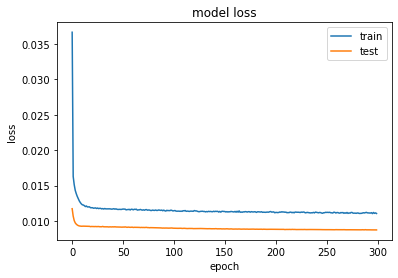

Test RMSE: 0.602


In [32]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=300, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

And compare the actual and prediction on first 500 points of the database.

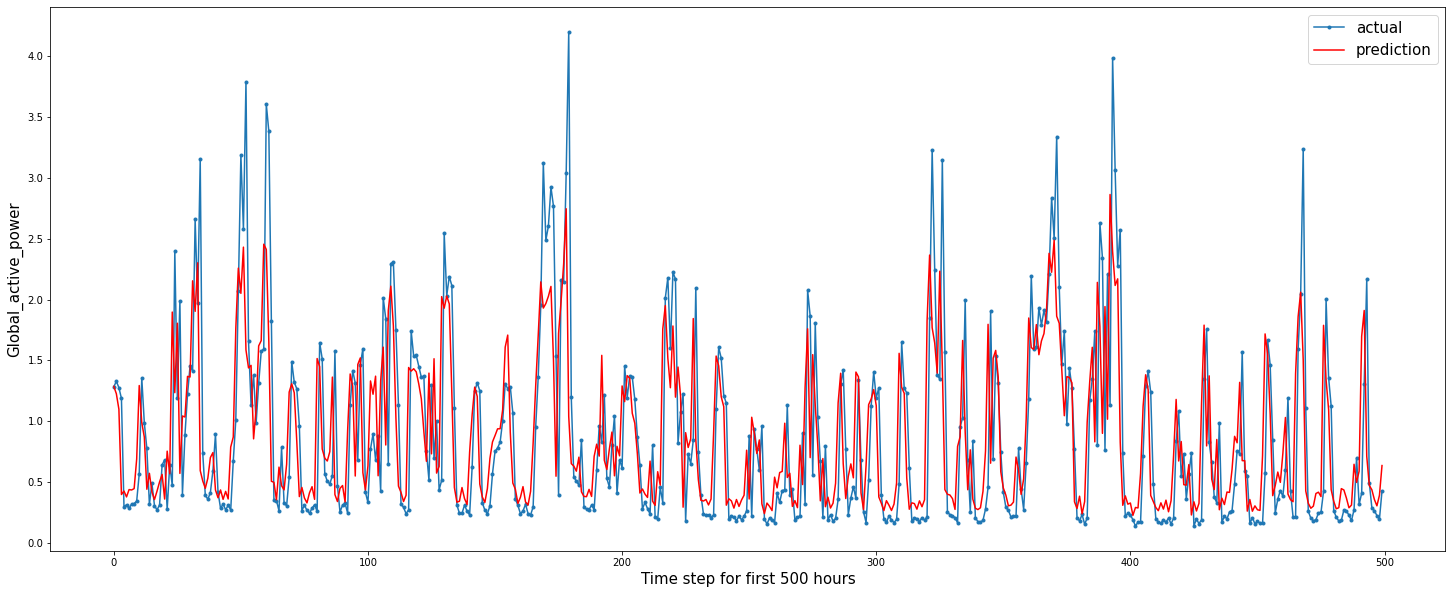

In [33]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

NOT BAD, let check the comparison of actual and prediction on 1000 data points from the 25,000 to 26,000.

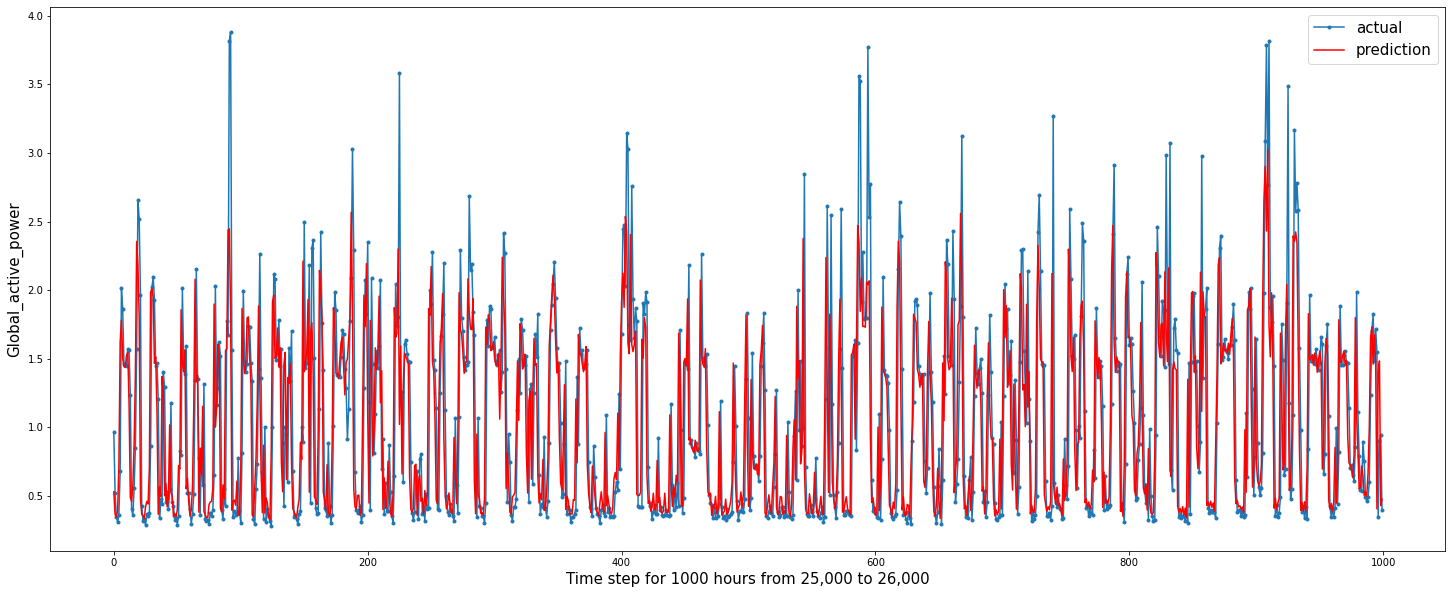

In [34]:
aa=[x for x in range(1000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[25000:26000], marker='.', label="actual")
plt.plot(aa, inv_yhat[25000:26000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for 1000 hours from 25,000 to 26,000', size=15)
plt.legend(fontsize=15)
plt.show()

<h3> Conclusions<h3>

In this Notebook, I practice to use the LSTM to fit and predict household electric power consumption. 

+ Consideration of the amount of input data is important to balance model accuracy and computation cost.

+ The database can be used 30% for fitting purposes and the rest can be used to validate the model.